<a href="https://www.kaggle.com/code/enricofindley/cat-dog-classification-using-cnn?scriptVersionId=138326571" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

#  Cat and Dog Image Classification Using CNN

# Importing dependencies

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Data Collecting:
* **Load data from api**
* **Save data to variable**

In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

--2023-07-30 04:33:17--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip’

cats_and_dogs.zip   100%[===================>]  67.43M   154MB/s    in 0.4s    

2023-07-30 04:33:17 (154 MB/s) - ‘cats_and_dogs.zip’ saved [70702765/70702765]

Archive:  cats_and_dogs.zip
   creating: cats_and_dogs/
  inflating: cats_and_dogs/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/cats_and_dogs/
  inflating: __MACOSX/cats_and_dogs/._.DS_Store  
   creating: cats_and_dogs/test/
  inflating: cats_and_dogs/test/48.jpg  
   creating: __MACOSX/cats_and_dogs/test/
  inflating: __MACOSX/cats_and_dogs/test/._48.jpg  
  inflating: cats_and_dogs/test/49.jpg  
  inflating: 

# Data pre-processing:
* **Load data to image data generator for easier pre-processing**
* **Plot random image to explore and learn the data**
* **Image augmentation for more accurate model**

In [3]:
# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory("cats_and_dogs/train",target_size=((IMG_HEIGHT, IMG_WIDTH)), batch_size=batch_size, class_mode="binary")
val_data_gen = validation_image_generator.flow_from_directory("cats_and_dogs/validation",target_size=((IMG_HEIGHT, IMG_WIDTH)), batch_size=batch_size, class_mode="binary")
test_data_gen = test_image_generator.flow_from_directory("cats_and_dogs/test",target_size=((IMG_HEIGHT, IMG_WIDTH)), batch_size=batch_size, classes=["."], class_mode="binary", shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


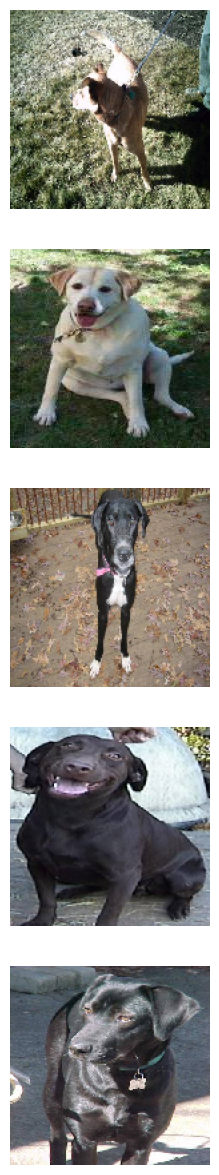

In [4]:
# Plot random image
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


Found 2000 images belonging to 2 classes.


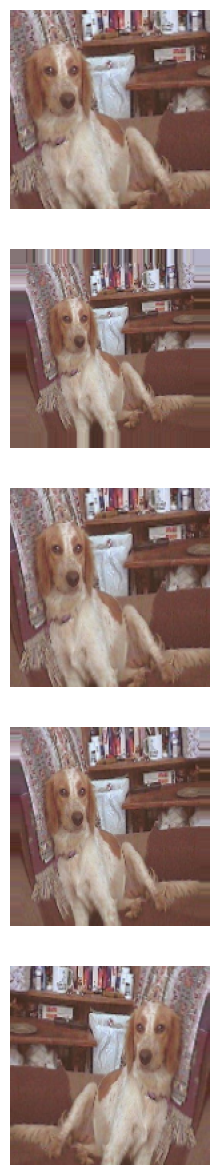

In [5]:
# Image augmentation
train_image_generator = ImageDataGenerator(rescale=1./255,shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

# Training, Validiation, and Testing:
* **Initialize model**
* **Training model + validation model**

In [6]:
# Create CNN Model
model = Sequential()
model.add(Conv2D(IMG_HEIGHT, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(IMG_HEIGHT*2, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2))
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 150)     4200      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 150)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 300)       405300    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 300)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 388800)            0         
                                                                 
 dense (Dense)               (None, 64)                2

In [7]:
# Training
history = model.fit(train_data_gen, steps_per_epoch=len(train_data_gen), epochs=epochs, validation_data=val_data_gen, validation_steps=len(val_data_gen))

Epoch 1/15
16/16 [==============================] - 48s 2s/step - loss: 1.3219 - accuracy: 0.5020 - val_loss: 0.6909 - val_accuracy: 0.5050
Epoch 2/15
16/16 [==============================] - 17s 1s/step - loss: 0.6930 - accuracy: 0.5275 - val_loss: 0.6841 - val_accuracy: 0.5440
Epoch 3/15
16/16 [==============================] - 17s 1s/step - loss: 0.6791 - accuracy: 0.5725 - val_loss: 0.6726 - val_accuracy: 0.5260
Epoch 4/15
16/16 [==============================] - 17s 1s/step - loss: 0.6720 - accuracy: 0.5810 - val_loss: 0.6662 - val_accuracy: 0.6120
Epoch 5/15
16/16 [==============================] - 17s 1s/step - loss: 0.6534 - accuracy: 0.6055 - val_loss: 0.6362 - val_accuracy: 0.6210
Epoch 6/15
16/16 [==============================] - 17s 1s/step - loss: 0.6360 - accuracy: 0.6400 - val_loss: 0.6268 - val_accuracy: 0.6280
Epoch 7/15
16/16 [==============================] - 17s 1s/step - loss: 0.6073 - accuracy: 0.6695 - val_loss: 0.6781 - val_accuracy: 0.5780
Epoch 8/15
16/16 [==

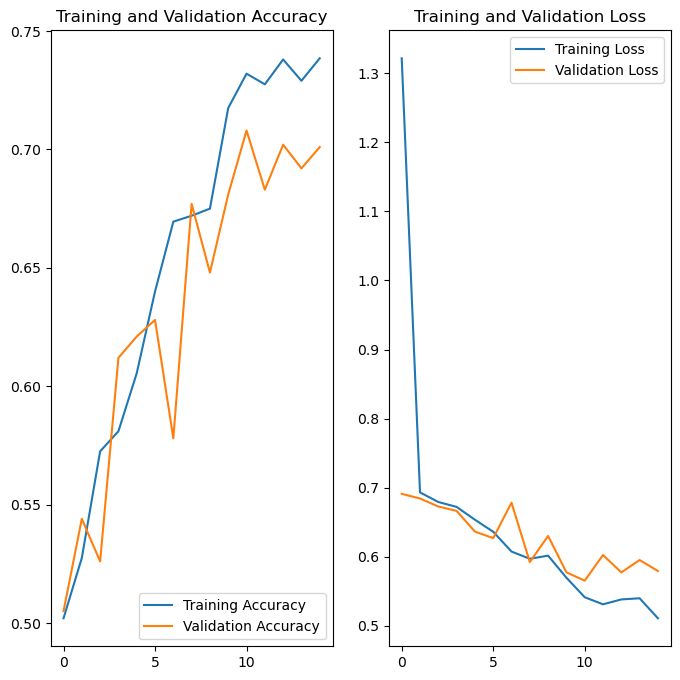

In [8]:
# Plot accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [9]:
# Testing
predictions = model.predict(test_data_gen)
probabilities = [1 if a[0]<a[1] else 0 for a in predictions]

1/1 [==============================] - 2s 2s/step


In [10]:
print(predictions)

[[-0.53286296  0.11262703]
 [ 1.1084006  -0.5426667 ]
 [ 1.605069   -1.8402785 ]
 [-2.8203578   0.9794009 ]
 [ 1.0712845  -1.2600853 ]
 [-0.08590684  0.1531689 ]
 [-1.1044227   0.18902655]
 [ 0.806026   -0.6539819 ]
 [ 0.36381626  0.02196147]
 [-2.5554209   0.95088696]
 [-0.46011728 -0.649763  ]
 [ 0.111526    0.15614435]
 [ 0.11310982 -0.28269956]
 [ 0.4131233   0.787172  ]
 [ 0.48830682 -0.54573375]
 [-0.83955336 -1.2185595 ]
 [-0.52075744  0.19072242]
 [-2.0478117   0.7101832 ]
 [-0.08273534 -0.02757296]
 [ 0.04242585 -0.25870478]
 [ 1.0154281  -0.98273385]
 [-1.0455842   0.15221287]
 [ 0.71042675 -1.1280707 ]
 [-0.14313997  0.6504465 ]
 [-2.3071284   0.75370455]
 [ 0.6618882  -0.7842539 ]
 [-0.06935895 -0.8877466 ]
 [-0.44865888  0.11423974]
 [ 0.03952872 -0.32198536]
 [-0.04159043 -0.72346234]
 [ 0.565945   -0.47989655]
 [ 1.0205902  -1.6491075 ]
 [-1.2884318  -0.01404821]
 [-6.769583    1.6301583 ]
 [-0.0845753  -0.19134264]
 [-0.9556055  -0.16851099]
 [-4.6929455   1.0122164 ]
 

In [11]:
print(len(probabilities))

50


In [12]:
# 11
testing_label =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, label in zip(probabilities, testing_label):
  if round(probability) == label:
    correct +=1

percentage_identified = (correct / len(testing_label)) * 100

passed_challenge = percentage_identified >= 63

print(f"Correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

Correctly identified 72.0% of the images of cats and dogs.
